<a href="https://colab.research.google.com/github/hyeonji0401/CUDA_practice/blob/main/thread_hierarchy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4-1. CUDA 스레드 계층 구조

**1. CUDA 스레드 계층**
- 스레드 -> 워프 -> 블록 -> 그리드로 이루어짐

1) 스레드
- 계층 구조에서 가장 작은 단위
- CUDA 연산을 수행하거나 CUDA 코어르 사용하는 기본 단위
- 커널 코드는 모든 스레드에 공우되며 각 스레드가 독립적으로 커널 코드를 수행

2) 워프
- 계층 구조의 두번째 계층
- 32개의 스레드를 하나로 묶은 것을 말하며 CUDA의 기본 수행단위
- **기본수행단위 :** 한 워프에 속한 스레드들은 하나의 제어 장치에 의해 제어됨
- GPU의 SIMT구조에서 멀티 스레드의 단위가 되는 것이 워프임
=> 즉 하나의 명령에 따라 32개의 스레드가 동시에 움직임

3) 블록(스레드 블록)
- 워프보다 상위 스레드 그룹으로 워프들의 집합을 의미함
- 하나의 블록에 포함된 각 스레드는 자신만의 고유한 스레드 번호(thread ID)를 가짐

  : 동일한 블록 안에는 동일한 번호를 갖는 스레드가 없음
- 각 블록은 자신만의 고유한 블록 번호(block ID)가 있음

=> 원하는 스레드를 지정하기 위해서는 블록 번호와 스레드 번호를 모두 사용해야함

  : 블록 내 스레드는 최대 3차원 번호를 가질 수 있음

4) 그리드
- 계층 구조에서 가장 상위 단계
- 여러 개의 블록을 포함하는 블록들의 그룹
- 하나의 그리드에 포함된 블록들은 서로 다른 자신만의 번호를 가지며 그리드 내 블록 또한 최대 3차원 형태로 배치될 수 있음
- 커널이 호츨되면 그리드가 생성됨

=> 하나의 그리드는 하나의 커널 호출과 1:1 대응되게 해당 커널을 수행한 스레드를 생성함


**2. CUDA 스레드 계층을 위한 내장 변수들**

내장 변수 : 현재 그리드 및 블록의 형태와 각 스레드가 자신이 속한 블록 번호, 그리고 사진의 스레드 번호를 확인할 수 있음
> 스레드들이 자신이 처리할 데이터가 무엇인지 알기 위해서는 자신이 어떤 블록에 속해 있는지, 블록 내 자신의 스레드 번호를 알아야함

> 내장 변수의 값은 커널이 수행될 때 결정되면 각 스레드는 자신에게 할당된 내장 변수 값을 참조할 수 있음

> 내장 변수 값을 코드에서 수정할 수는 없음

**가. grimDim**

- 그리드 형태 정보를 담고 있는 구조체 내장 변수
- x,y,z멤버가 각각 첫번쨰 차원부터 세번째 차원의 크기를 담고 있음
- 각 차원의 길이는 1이상 양의 정수로 정의되어야하며, 소수점 값을 가질 수 없음
- 사용하지 않는 차원의 크기는 1로 표현됨
- 커널 내 모든 스레드가 공유함

   ex) x=3, y=2, z=1 : 3x2 크기의 2차원 형태로 이루어져있음

**나. blockIdx**

- 현재 스레드가 속한 블록의 번호를 담고 있는 구조체형 내장 변수
- 블록 번호는 0번부터 시작함
- 한 블록에 속한 모든 스레드들이 모두 공유하게 됨
  ex) blockIdx.x =2, blockIdx=2, blockIdx=0 : 2X2 크기의 2차원 형태로 이루어져있음

**다. blockDim**
- 블록의 형태 정보를 담고 있는 구조체형 내장 변수
- 각 차원의 길이는 1이상의 양의 정수로 정의되어야하며 소수점 값을 가질 수 없음
- 그리드 내 모든 스레드가 공유하게 됨

**라. threadIdx**
- 블록 내에서 현재 스레드가 부여받은 스레드 번호를 담고 있는 구조체형 내장 변수
- 0부터 시작하며 최대 3차원의 번호를 가질 수 있음
  ex) threadIdx.x = 2, threadIdx.y=2, threadIdx.z=0 : 2x2에 위치함

*** 스레드 번호와 워프의 구성**
> 워프는 연속된 32개의 스레드로 구성됨

> 스레드의 연속성은 threadIdx.x, y, z차원 순으로 결정됨

[즉 (0,0,0)~(31,0,0)번 스레드가 하나의 워프를 구성함]

> 커널의 성능에 큰 영향을 미치는 요소 중 하나인 메모리 접근 패턴을 이해하려면 워프를 구성하는 스레드를 정확히 인지해야함

> 워프 수준에서 스레드들 사이의 작업을 분배할 때도 중요한 역할을 함


**3. 그리드 및 블록의 최대 크기 제한**

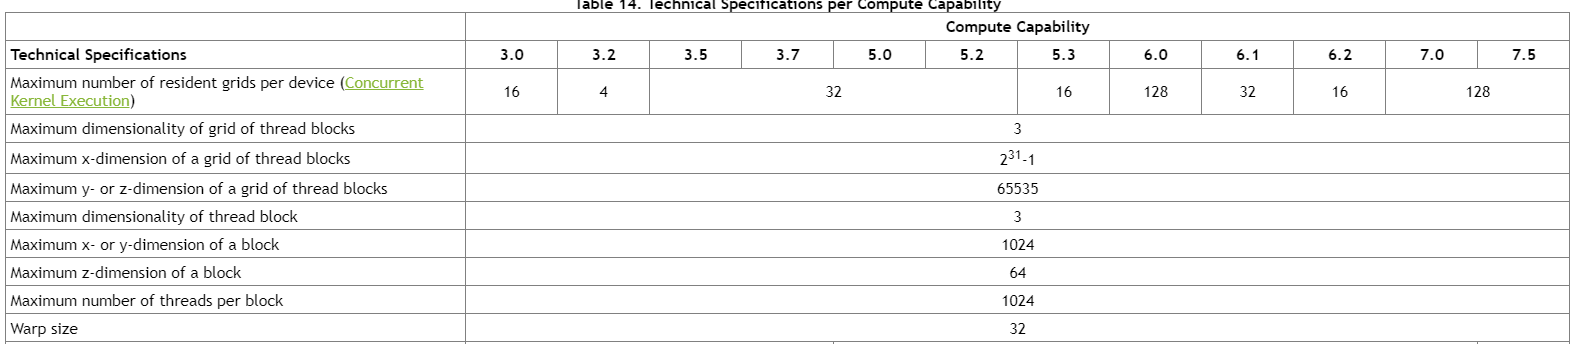
- 위 그림은 엔비디아 CUDA 공식 가이드에 있는 compute capability표 중 일부로 그리드 및 블록의 최대 크기를 보여줌

가. 그리드의 크기
- 그리드는 최대 3차원 형태
- x-차원의 최대 길이 : 2^31-1
- y-차원의 최대 길이 : 65,535
- z-차원의 최대 길이 : 65,535

나. 블록의 크기
- 블록은 최대 3차원 형태
- x-차원의 최대 크기 : 1,024
- y-차원의 최대 크기 : 1,024
- z-차원의 최대 크기 : 24
- 블록하나가 가질 수 있는 최대 스레드 개수 : 1,024개
- 블록이 가지는 스레드 수 : x-차원 * y-차원 * z-차원

# 4-2 CUDA 스레드 구조와 커널 호출
- 커널을 수행할 그리드와 블록의 형태를 지정하는 법 알아보기

**1. 스레드 레이아웃 설정 및 커널 호출**
- **스레드 레이아웃(thread layout)**

  : 스레드의 배치 형태를 지정하는 말로 그리드와 블록의 형태로 정의됨
  : 커널 호출 시 성정하며, 커넣을 호출할 때 사용한 <<<>>>실행 구성 문법을 통해 전달됨


```
Kenel<<<그리드의 형태, 블록의 형태>>>()
```
<<<1,n>>>의 의미
- 커널에서 사용할 스레드의 수를 n개로 지정

=> (1,1,1)크기의 그리드를 사용하며 블록의 크기는 (n,1,1)로 설정하는 말임

=> 하나의 블록을 가지는 그리드를 사용하고 블록은 x-차원의 길이가 n인 1차원 블록을 스레드 레이아웃으로 잡는 것을 의미
- gridDim = (1,1,1)
- blockDim = (n,1,1)
- blockIdx = (0,0,0)
- threadIdx = (n-1,0,0)


**만약 그리드와 블록이 1차원이 아닌 경우**


```
Kernel<<<(3,2,1),(6,4,2)>>>
```
이와 같이 차원의 크기를 인자로 전달해 줄 수 있음





**dim3을 통한 스레드 레이아웃 지정**

**dim3**: x,y,z 멤버 변수를 가지는 구조체로 각각 x-차원, y-차원, z-차원의 크기를 담음



```
DIm3 dimGrid(4,1,1);
dim3 dimBlock(8,1,1);
kernel<<<dimGrid, dimBlock>>>();
```



**2. 스레드 레이아웃 설정 및 확인 예제**

In [ ]:
%%cuda

#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

__global__ void checkIndex(void){
    printf("threadIdx:(%d, %d, %d) blockIdx:(%d, %d, %d) blockDim(%d, %d, %d) gridDim:(%d, %d, %d)\n",
           threadIdx.x, threadIdx.y, threadIdx.z
           ,blockIdx.x, blockIdx.y, blockIdx.z
           ,blockDim.x, blockDim.y, blockDim.z,
           gridDim.x, gridDim.y, gridDim.z);
}

int main(void){

               dim3 dimBlock(3,1,1); //or dimblock(3) => 크기가 3인 1차원 블록
               dim3 dimGrid(2,1,1); //or dimGrid(2)  => 크기가 2인 1차원 그리드

               printf("dimGrid.x=%d dimGrid.y=%d, dimGrid.x=%d\n", dimGrid.x, dimGrid.y, dimGrid.z);
               printf("dimBlock.x=%d dimBlock.y=%d, dimBlock.x=%d\n", dimBlock.x, dimBlock.y, dimBlock.z);

               checkIndex<<<dimGrid, dimBlock>>>();
               cudaDeviceSynchronize();
               return 0;
}

dimGrid.x=2 dimGrid.y=1, dimGrid.x=1
dimBlock.x=3 dimBlock.y=1, dimBlock.x=1
threadIdx:(0, 0, 0) blockIdx:(0, 0, 0) blockDim(3, 1, 1) gridDim:(2, 1, 1)
threadIdx:(1, 0, 0) blockIdx:(0, 0, 0) blockDim(3, 1, 1) gridDim:(2, 1, 1)
threadIdx:(2, 0, 0) blockIdx:(0, 0, 0) blockDim(3, 1, 1) gridDim:(2, 1, 1)
threadIdx:(0, 0, 0) blockIdx:(1, 0, 0) blockDim(3, 1, 1) gridDim:(2, 1, 1)
threadIdx:(1, 0, 0) blockIdx:(1, 0, 0) blockDim(3, 1, 1) gridDim:(2, 1, 1)
threadIdx:(2, 0, 0) blockIdx:(1, 0, 0) blockDim(3, 1, 1) gridDim:(2, 1, 1)



**3. 큰 벡터에 대한 벡터 합 CUDA 프로그램 - 스레드 레이아웃**

이전 장에서 다음과 같은 식을 수행했을 때 연산이 제대로 수행되지 않았음

```
vecAdd<<<1,NUM_DATA>>>>>(da,db,dc);
```

이 커널 호출에 사용한 스레드 레이아웃은 x-차원 길이가 NUM_DATA인 1차원 블록 1개 갖는 그리드임

현재 한 블록이 가질 수 있는 x-차원 최대 길이는 1,024이며 한 블록이 가질 수 있는 스레드 수는 1,024임

=> NUM_DATA는 1,024를 넘을 수 없음

**그러면 큰 벡터 처리를 위해서는 스레드 레이아웃을 어떻게 잡아야할까?**
- 블록을 여러 개 사용함

=> 여러 개의 블록을 가진 그리드 생성

**블록의 개수를 정하는 방법**

- 한 블록이 1,024개의 스레드 만을 가질 수 있으므로 데이터 개수/1,024를 하면 됨
- 소수점을 가질 수 없으므로 올림 처리를 해야함

**수정된 커널 코드**


```
vecAdd<<<ceil(NUM_DATA/1024),1024>>>(da,db,dc);
```
- ceil : 올림 연산 함수
- 마지막 블록에서 담당한 데이터가 없는 스레드도 발생함(이에 대한 추가 조치는 5장에서 다룬다고 함)









**전체 코드 수정**

In [2]:
%%cuda

# include "cuda_runtime.h"
# include "device_launch_parameters.h"

# include <stdio.h>
# include <stdlib.h>
# include <string.h>

// The size of the vector
# define NUM_DATA 1030

// Simple vector sum kernel (Max vector size : 1024)
__global__ void vecAdd(int* _a, int* _b, int* _c) {
    int tID = threadIdx.x;
    _c[tID] = _a[tID] + _b[tID];
}

int main(void)
{
    int* a, * b, * c, * h_c;    // Vectors on the host
    int* da, * db, * dc;        // Vectors on the device

    int memSize = sizeof(int) * NUM_DATA;
    printf("%d elements, memSize = %d bytes\n", NUM_DATA, memSize);

    // Memory allocation on the host-side
    a = new int[NUM_DATA]; memset(a, 0, memSize);
    b = new int[NUM_DATA]; memset(b, 0, memSize);
    c = new int[NUM_DATA]; memset(c, 0, memSize);
    h_c = new int[NUM_DATA]; memset(h_c, 0, memSize);

    // Data generation
    for (int i = 0; i < NUM_DATA; i++) {
        a[i] = rand() % 10;
        b[i] = rand() % 10;
    }

    // Vector sum on host (for performance comparision)
    for (int i = 0; i < NUM_DATA; i++)
        h_c[i] = a[i] + b[i];

    //****************************************//
    //******* Write your code - start ********//

    // 1. Memory allocation on the device-side (da, db, dc)
    cudaMalloc(&da, memSize); cudaMemset(da, 0, memSize); //할당 및 초기화
	  cudaMalloc(&db, memSize); cudaMemset(db, 0, memSize);
	  cudaMalloc(&dc, memSize); cudaMemset(dc, 0, memSize);

    // 2. Data copy : Host (a, b) -> Device (da, db)
    cudaMemcpy(da, a, memSize, cudaMemcpyHostToDevice);
    cudaMemcpy(db, b, memSize, cudaMemcpyHostToDevice);

    // 3. Kernel call
    vecAdd<<<ceil(NUM_DATA/1024),1024>>>(da,db,dc);

    // 4. Copy results : Device (dc) -> Host (c)
    cudaMemcpy(c, dc, memSize, cudaMemcpyDeviceToHost);

    // 5. Release device memory (da, db, dc)
    cudaFree(da);
    cudaFree(db);
    cudaFree(dc);

    //******** Write your code - end *********//
    //****************************************//

    // Check results
    bool result = true;
    for (int i = 0; i < NUM_DATA; i++) {
        if (h_c[i] != c[i]) {
            printf("[%d] The resutl is not matched! (%d, %d)\n"
                , i, h_c[i], c[i]);
            result = false;
        }
    }

    if (result)
        printf("GPU works well!\n");

    // Release host memory
    delete[] a; delete[] b; delete[] c; //동적으로 할당된 배열 해제

    return 0;
}

1030 elements, memSize = 4120 bytes
[1024] The resutl is not matched! (1, 0)
[1025] The resutl is not matched! (7, 0)
[1026] The resutl is not matched! (8, 0)
[1027] The resutl is not matched! (7, 0)
[1028] The resutl is not matched! (5, 0)
[1029] The resutl is not matched! (13, 0)



**결과**
- 수정 전은 스레드 수 초과로 커널 자체가 실행되지 않아 전체 연산이 잘못되었지만 수정된 코드의 경우는 제한된 스레드로 커널은 수행함 그러나 1,025번째 원소부터는 잘못된 계산 결과가 나옴

**원인**


```
__global__ void vecAdd(int* _a, int* _b, int* _c) {
    int tID = threadIdx.x;
    _c[tID] = _a[tID] + _b[tID];
}
```

위의 코드 내용은 threadIdx내장 변수를 통해 자신의 스레드 번호를 가져오고 자신의 스레드 번호화 같은 번호의 벡터 원소에 대한 벡터 합을 수행하도록 되어있음

=> 한 블록 내에서는 모든 스레드가 서로 다른 번호를 갖지만 다른 블록에서는 같은 번호를 가지는 스레드가 있음

=> 따라서 번호가 중복되는 1,025번째 연산부터는 고려하지 않은 계산 방식임

**해결방안**

- 각 스레드가 속한 블록 번호를 고려해 담당할 데이터의 번호를 결정해야함

=> **스레드 인덱싱** 필요

- **스레드 인덱싱** : 스레드 레이아웃 및 알고리즘에 맞추어 스레드의 번호를 정의하는 과정
